Coin is tossed 10 times. If 6 or fewer heads, win back £1 plus additional £1. 7 or more is a loss

$P(Y=y) = {N \choose y} r^y (1-r)^{N-y}$

$Y$: RV representing number of heads

$y$: number of heads observed

$N$: number of tosses, 10 for this game.

$r$: Unknown, probability of getting a head. 

To find the probability of winning we would like to estimate $r$ based on observing the game. Effectively we want to calculate $p(r|y_N)$, the conditional probability of $r$ given an observed number of heads $y_N$.

$p(r|y_N) = \frac{P(y_N|r)p(r)}{P(y_N)}$

Examine the components individually.

#### Likelihood
$P(y_N|r)$: The probability of observing our data given a particular value of $r$. 

#### Prior
$p(r)$: Any beliefs we have about the distribution of $r$ before observing any data. Our best guess. 

#### Marginal distribution
$P(y_N)$: The likelihood of all data averaged over all parameter values. Usually quite hard to calculate. 

#### Posterior 
$p(r|y_N)$: Distribution of interest. When we get new evidence we update $p(r)$ to take this evidence into account. 

## Method
1. Guess a prior
   - It is convenient to pick a prior distribution that will result in a posterior which is the same form as the prior ("Conjugate")
   - The likelihood-prior combination is the one that is conjugate
2. In the case of our coin game, we know our likelihood is binomial, so choose a beta prior
   - Recall that the beta itself has 2 parameters $\alpha$ and $\beta$ that affect the shape. 
3. Observe $y_N$ and update the posterior. 

# 3 scenarios
We investigate 3 scenarios that comprise different priors that describe different beliefs we may have about $r$.

In these scenarios, we choose different beta distributions. $\alpha$ and $\beta$ describe the numbers of heads and tails in $(\alpha + \beta)$ previous tosses. 

## No prior knowledge
We assume that $r$ can take any value between 0 and 1. This comes from a beta distribution with $\alpha=1$ and $\beta=1$.


In [30]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import beta
import numpy as np



/home/mog/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/mog/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/home/mog/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/mog/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/home/mog/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/mog/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid va

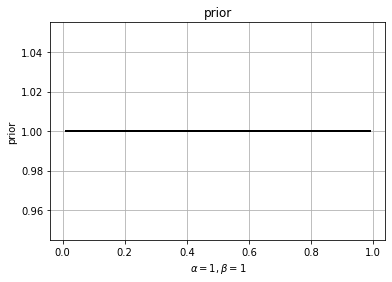

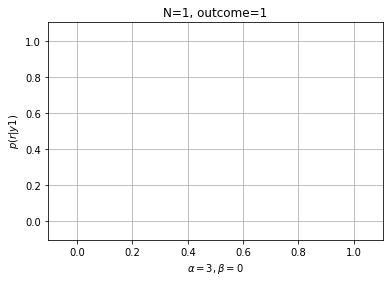

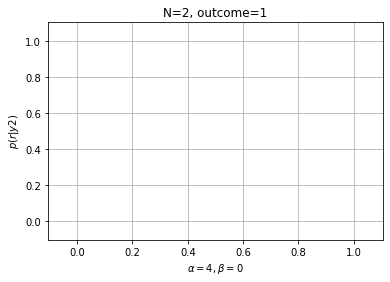

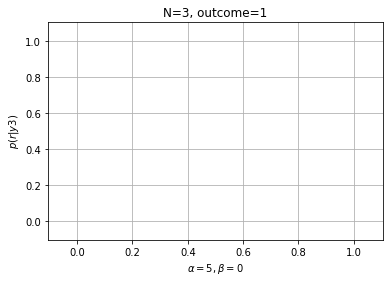

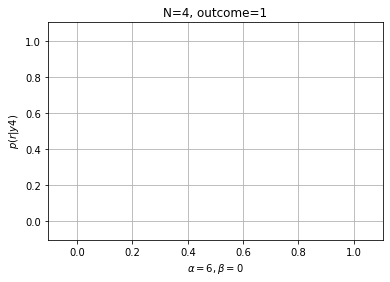

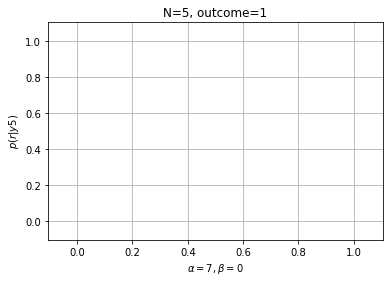

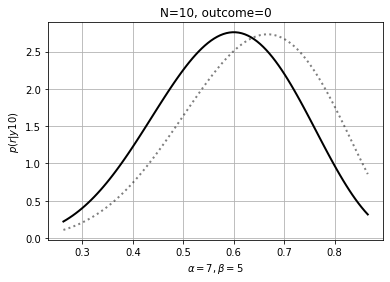

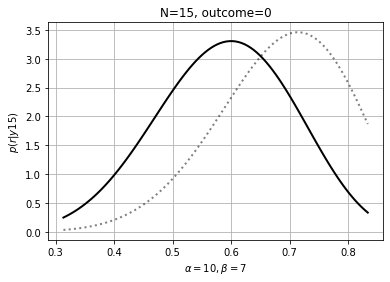

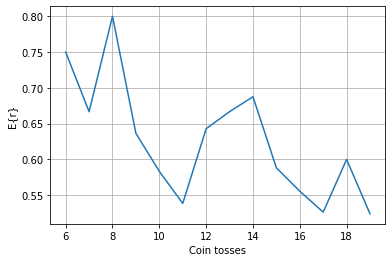

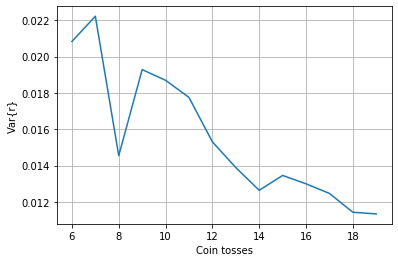

In [31]:
np.random.seed(12321312)

from scipy.stats import binom

toss = binom(n=1, p=0.5)

def adjust_posterior(result, a, b, N, y_N1):
    # result: 1 or 0, outcome of coin toss. 1 = heads
    # a = current value of alpha before the result
    # b = current value of beta before the result
    # N = number of tosses including the current
    # y_n1 = number of head in the last iteration
    # returns: a beta distribution with the new parameters
    y_N = y_N1 + result
    new_a = a+y_N
    new_b = b+N-y_N
    return beta(a+y_N, b+N-y_N)

def plot_posterior(beta_obj, last_beta_obj, title, N):
    a, b = beta_obj.args
    x = np.linspace(beta.ppf(0.01, a, b),
                    beta.ppf(0.99, a, b), 100)

    plt.plot(x, beta_obj.pdf(x), 'k-', lw=2, label=f'beta({a}, {b})')
    if last_beta_obj is not None:
        plt.plot(x, last_beta_obj.pdf(x), 'k:', lw=2, label='previous', alpha=0.5)
    plt.title(title)
    ylabel = 'prior' if N == 0 else f'$p(r|y{N})$'
    plt.ylabel(f"{ylabel}")
    plt.xlabel(fr"$\alpha={a}, \beta={b}$")
    plt.grid()
    
    
def model_posterior(prior, num_tosses, display_step):
    # prior: beta distribution encoding the prior
    # num_tosses: total number of tosses to simulate
    # display_step: print every N, except the first N which are all printed
    
    heads = 0

    mean_r, var_r = [], []

    Ns = list(range(0,num_tosses))
    last_beta = None
    a, b = prior.args
    for N in Ns:
        if N == 0:
            plot_posterior(prior, last_beta, "prior", 0)
            last_beta = prior
            continue
        outcome = toss.rvs()
        heads += outcome
        beta_N = adjust_posterior(outcome, a, b, N, heads)
        if N <= display_step or N % display_step == 0:
            plt.figure()
            plot_posterior(beta_N, last_beta, f'N={N}, outcome={outcome}', N)
        last_beta = beta_N
        mean_r.append(beta_N.mean())
        var_r.append(beta_N.var())

    plt.figure()
    plt.plot(Ns[1:], mean_r)
    plt.grid()
    plt.xlabel('Coin tosses')
    plt.ylabel(r"E{r}")
    plt.figure()
    plt.plot(Ns[1:], var_r)
    plt.grid()
    plt.xlabel('Coin tosses')
    plt.ylabel(r"Var{r}")

    
model_posterior(beta(1, 1), 20, 5)

## Fair coin
Assume that 50 heads and 50 tails have been observed already, leading to a prior with $\alpha=50$ and $\beta=50$

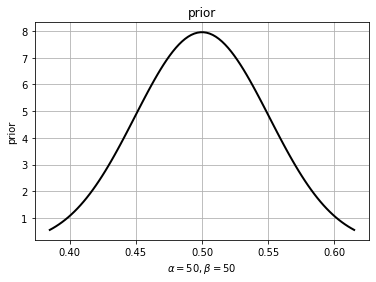

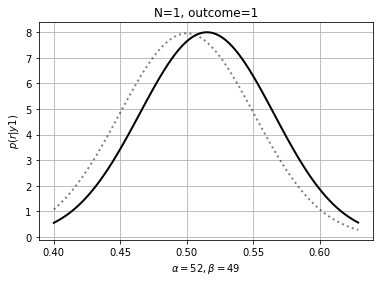

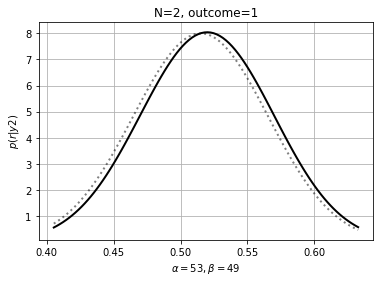

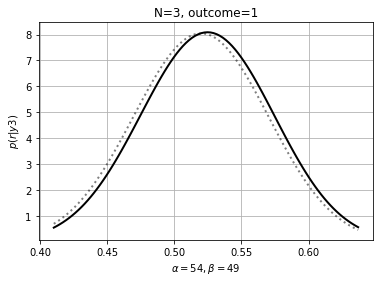

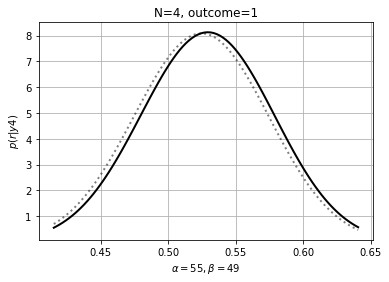

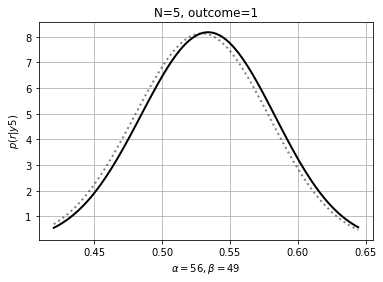

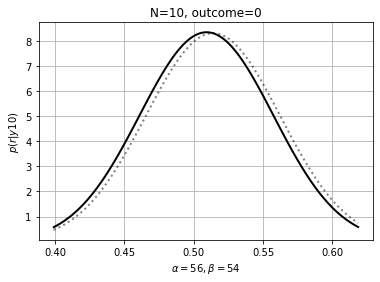

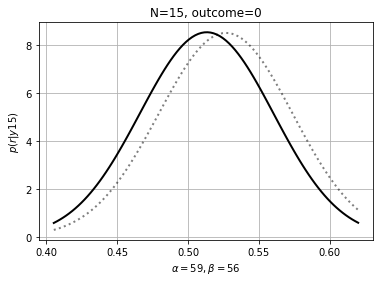

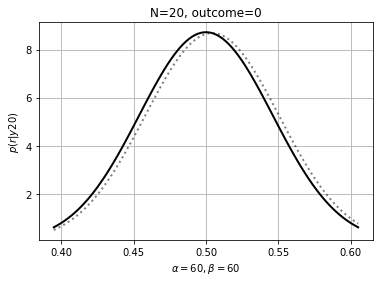

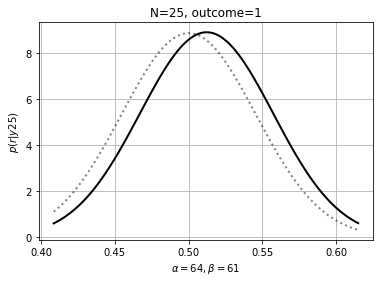

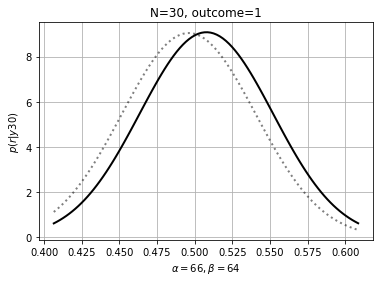

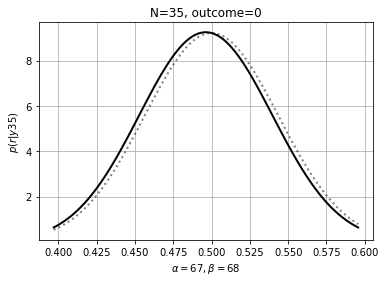

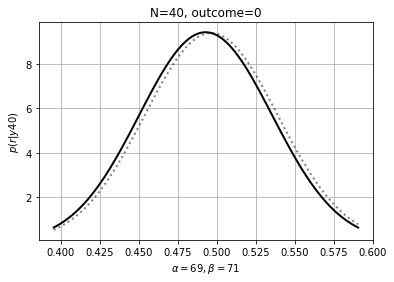

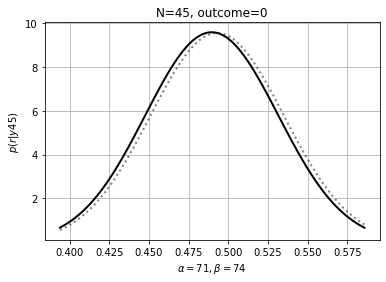

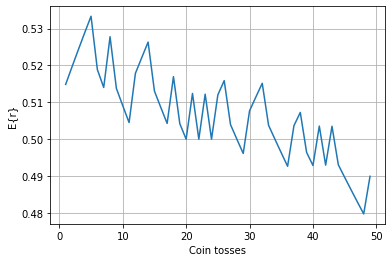

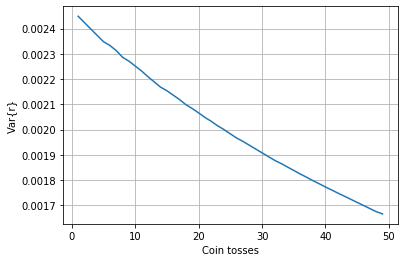

In [32]:
np.random.seed(12321312)
model_posterior(beta(50, 50), 50, 5)

## Biased coin

Beta with parameters $\alpha=5$, $\beta=1$

/home/mog/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/mog/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/home/mog/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/mog/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/home/mog/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/mog/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid va

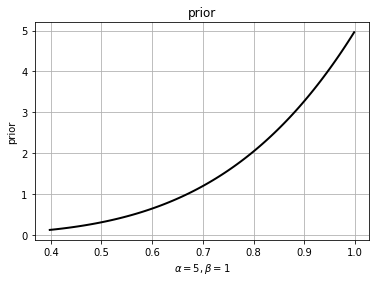

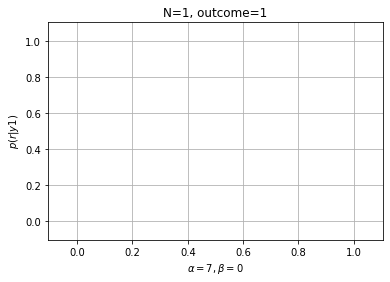

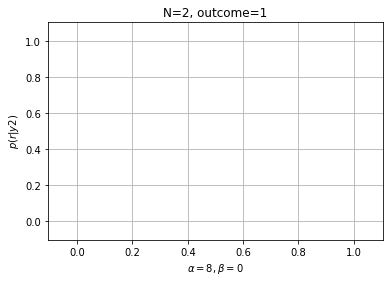

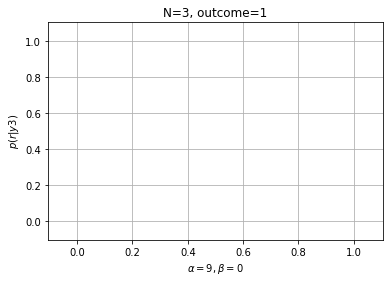

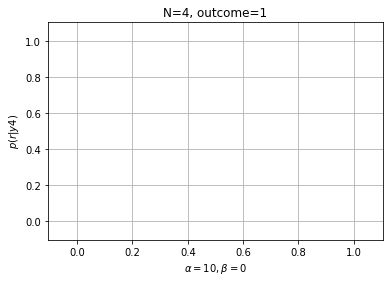

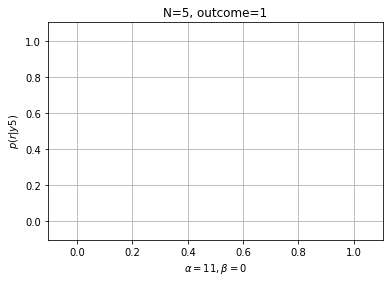

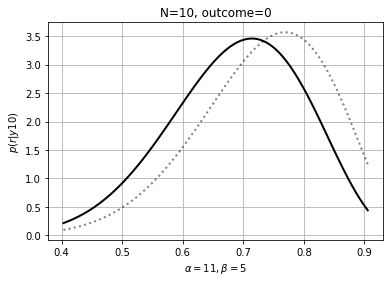

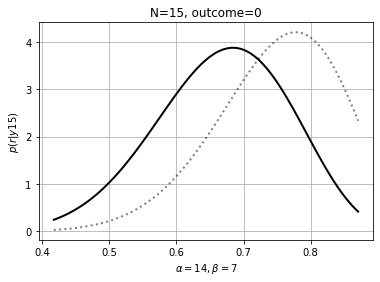

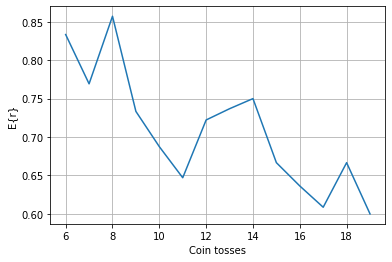

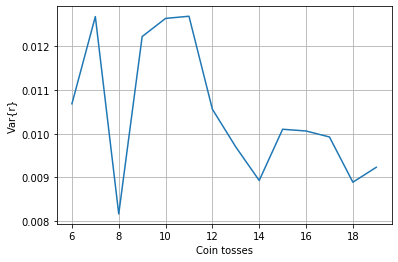

In [34]:
np.random.seed(12321312)
model_posterior(beta(5, 1), 20, 5)